In [1]:
import sys
sys.path.append(r'/Users/brendanliang/Code/brendans_bloomberg') 
import numpy as np
import pandas as pd
import math
import os
import subprocess
import shlex
import matplotlib.pyplot as plt
from datetime import datetime
from tools.helper.pandas_tools import find_col_index
from interface.company import Company
from interface.indicator import Yahoo_Indicator
from interface.forex import forex
from tools.plotting import plotter
import fmpsdk
from interface.data_sources.api_key import api_key

In [2]:
company = Company("GOOG")

# Share Price History

[datetime.date(2019, 6, 12)]


/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_11399/3713779325.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(company.price_history.dates, company.price_history.close/float(company.price_history.close[company_index]), label = company.profile.name)
/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_11399/3713779325.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(Yahoo_Indicator("^GSPC").dates, Yahoo_Indicator("^GSPC").close/float(Yahoo_Indicator("^GSPC").close[benchmark_index_index]), label = "S&P500")


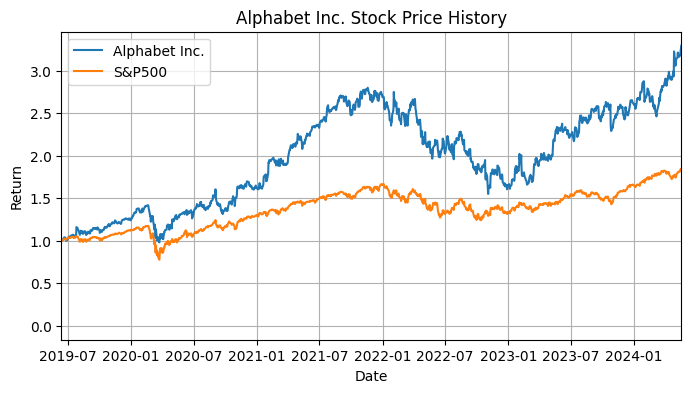

In [3]:
recency_bias = 0.25
proportion = 1 - recency_bias
start_date = company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)]
print(start_date)
company_index = np.where(company.price_history.dates == start_date)[0]
benchmark_index_index = np.where(Yahoo_Indicator("^GSPC").dates == start_date)[0]
plt.figure(figsize=(8, 4))  # Customize the figure size if needed
plt.plot(company.price_history.dates, company.price_history.close/float(company.price_history.close[company_index]), label = company.profile.name)
plt.plot(Yahoo_Indicator("^GSPC").dates, Yahoo_Indicator("^GSPC").close/float(Yahoo_Indicator("^GSPC").close[benchmark_index_index]), label = "S&P500")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title(f"{company.profile.name} Stock Price History")
plt.grid(True)
plt.xlim(start_date[0], company.price_history.dates[-1][0])
plt.legend()

# Financial Statement - Per Share

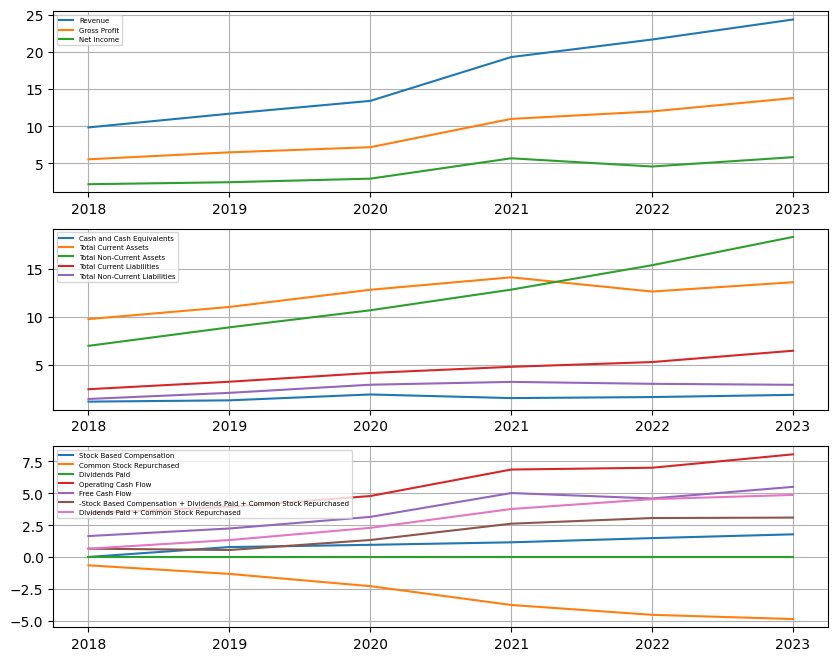

In [4]:
n = math.floor((1-proportion)*len(company.annual_income_statement.income_statement))
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 8))
year, revenue, gross_profit, net_income, shs_out = [], [], [], [], []
cashAndCashEquivalents, totalCurrentAssets, totalNonCurrenAssets, totalCurrentLiabilities, totalNonCurrentLiabilities = [], [], [], [], []
fcf, operating_cf, stock_comp, stock_repurchase, dividends =  [], [], [], [], []
for i in range(n):
    year.append(company.annual_income_statement.income_statement[i]['calendarYear'])
    revenue.append(company.annual_income_statement.income_statement[i]['revenue'])
    gross_profit.append(company.annual_income_statement.income_statement[i]['grossProfit'])
    net_income.append(company.annual_income_statement.income_statement[i]['netIncome'])
    shs_out.append(company.annual_income_statement.income_statement[i]['weightedAverageShsOut'])
    cashAndCashEquivalents.append(company.annual_balance_sheet.balance_sheet[i]['cashAndCashEquivalents'])
    totalCurrentAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentAssets'])
    totalNonCurrenAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentAssets'])
    totalCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentLiabilities'])
    totalNonCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentLiabilities'])
    stock_comp.append(company.annual_cashflow.cashflow[i]['stockBasedCompensation'])
    stock_repurchase.append(company.annual_cashflow.cashflow[i]['commonStockRepurchased'])
    dividends.append(company.annual_cashflow.cashflow[i]['dividendsPaid'])
    operating_cf.append(company.annual_cashflow.cashflow[i]['operatingCashFlow'])
    fcf.append(company.annual_cashflow.cashflow[i]['freeCashFlow'])
income_data, income_labels = [revenue, gross_profit, net_income], ["Revenue", "Gross Profit", "Net Income"]
balance_data, balance_labels = [cashAndCashEquivalents, totalCurrentAssets, totalNonCurrenAssets, totalCurrentLiabilities, totalNonCurrentLiabilities], ["Cash and Cash Equivalents", "Total Current Assets", "Total Non-Current Assets", "Total Current Liabilities", "Total Non-Current Liabilities"]
cashflow_data, cashflow_labels = [stock_comp, stock_repurchase, dividends, operating_cf, fcf, -np.array(stock_comp)-np.array(dividends)-np.array(stock_repurchase), -np.array(dividends)-np.array(stock_repurchase)], ["Stock Based Compensation", "Common Stock Repurchased", "Dividends Paid", "Operating Cash Flow", "Free Cash Flow", "-Stock Based Compensation + Dividends Paid + Common Stock Repurchased", "Dividends Paid + Common Stock Repurchased"]  

plotter(ax1, year, shs_out, income_labels, income_data, n)
plotter(ax2, year, shs_out, balance_labels, balance_data, n)
plotter(ax3, year, shs_out, cashflow_labels, cashflow_data, n)

# Historical Valuations

## Historical Valuation Plot

/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_11399/1964360759.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 200)


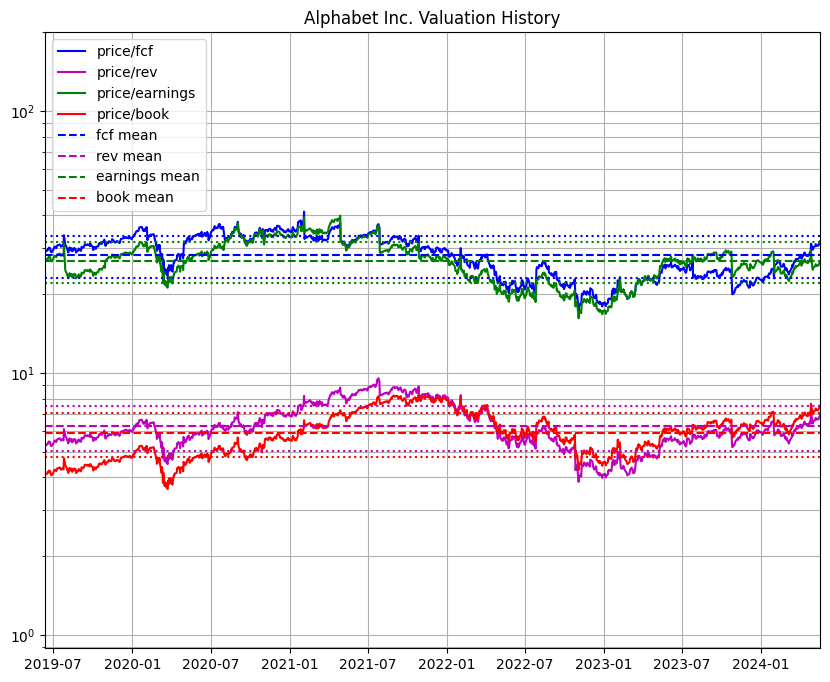

In [6]:
from tools.ttm_calculator import trailing_twelve_month
from datetime import datetime
ttm_cashflow = trailing_twelve_month(company.symbol, "cashflow_statement")
ttm_balance_sheet = trailing_twelve_month(company.symbol, "balance_sheet")
ttm_income_statement = trailing_twelve_month(company.symbol, "income_statement")
dates = []
price_fcf = []
price_rev = []
price_earnings = []
price_book = []

for i in range(len(company.price_history.close)):
    date = company.price_history.dates[i]
    price = company.price_history.close[i]
    dates.append(date)
    for j in range(len(ttm_cashflow)-1):
        if date > ttm_cashflow[0]["fillingDate"]:
            index = 0
            break
        if  date < ttm_cashflow[j]["fillingDate"] and date > ttm_cashflow[j+1]["fillingDate"]:
            index  = j + 1
            break
        if date < ttm_cashflow[-1]["fillingDate"]:
            index = -1
            break
    price_fcf.append(price / (ttm_cashflow[index]["freeCashFlow"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_rev.append(price / (ttm_income_statement[index]["revenue"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_earnings.append(price / (ttm_income_statement[index]["netIncome"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_book.append(price / ((ttm_balance_sheet[index]["totalAssets"] - ttm_balance_sheet[index]["totalLiabilities"]) / ttm_income_statement[index]["weightedAverageShsOut"]))

fig, ax = plt.subplots(figsize=(10, 8))

plt.yscale('log')
plt.ylim(0, 200)
plt.title(f"{company.profile.name} Valuation History")
plt.xlim(company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0], company.price_history.dates[-1][0])
ax.plot(dates, price_fcf, label= "price/fcf", color = "b")
ax.plot(dates, price_rev, label= "price/rev", color = "m")
ax.plot(dates, price_earnings, label= "price/earnings", color = "green")
ax.plot(dates, price_book, label= "price/book", color = "red")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])), 
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="--", label = "fcf mean")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="dotted")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="dotted")

ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="--", label = "rev mean")
ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="dotted")
ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="dotted")

ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
              company.price_history.dates[-1][0], colors="green", linestyles="--", label = "earnings mean")
ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="green", linestyles="dotted")
ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="green", linestyles="dotted")

ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="--", label = "book mean")
ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="dotted")
ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="dotted")
ax.grid(which="both")
ax.legend(loc = "upper left")

## Simple Monte Carlo DCF Forecasting and Valuation

In [7]:
from tools.wacc import wacc
from datetime import timedelta
interations = 1000
forecast_years = 3
discount_rate = wacc(company.symbol)
print(f"Discount Rate = {discount_rate}")
shares_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    shares_rate.append(ttm_income_statement[i]["weightedAverageShsOut"] / ttm_income_statement[i+ 1]["weightedAverageShsOut"] - 1)
shares_rate_mean, shares_rate_std = np.mean(shares_rate), np.std(shares_rate)

Discount Rate = 0.09887750693349864


### FCF Valuation

In [ ]:
fcf_rate = []
for i in range(math.floor(len(ttm_cashflow) * recency_bias)):
    fcf_rate.append(ttm_cashflow[i]["freeCashFlow"] / ttm_cashflow[i+ 1]["freeCashFlow"] - 1)
fcf_rate_mean, fcf_rate_std = np.mean(fcf_rate), np.std(fcf_rate)
fcf_valuation_mean = np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):]))
fcf_valuation_std = np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):]))
fcf_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        fcf_valuation_scalar = np.random.normal(fcf_valuation_mean, fcf_valuation_std)
        fcf_rate_scalar = np.random.normal(fcf_rate_mean, fcf_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = fcf_valuation_scalar * ttm_cashflow[0]["freeCashFlow"] * (1 + fcf_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    fcf_fair_value.append(current_year_value)

fcf_mean_price, fcf_std_price, year = [], [], []
for i, forecast in enumerate(fcf_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    fcf_mean_price.append(np.mean(forecast))
    fcf_std_price.append(np.std(forecast))

### Revenue Valuation

In [ ]:
rev_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    rev_rate.append(ttm_income_statement[i]["revenue"] / ttm_income_statement[i+ 1]["revenue"] - 1)
rev_rate_mean, rev_rate_std = np.mean(rev_rate), np.std(rev_rate)
rev_valuation_mean = np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):]))
rev_valuation_std = np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):]))
rev_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        rev_valuation_scalar = np.random.normal(rev_valuation_mean, rev_valuation_std)
        rev_rate_scalar = np.random.normal(rev_rate_mean, rev_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = rev_valuation_scalar * ttm_income_statement[0]["revenue"] * (1 + rev_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    rev_fair_value.append(current_year_value)

rev_mean_price, rev_std_price, year = [], [], []
for i, forecast in enumerate(rev_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    rev_mean_price.append(np.mean(forecast))
    rev_std_price.append(np.std(forecast))

### Earnings Valuation

In [ ]:
earnings_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    earnings_rate.append(ttm_income_statement[i]["netIncome"] / ttm_income_statement[i+ 1]["netIncome"] - 1)
earnings_rate_mean, earnings_rate_std = np.mean(earnings_rate), np.std(earnings_rate)
earnings_valuation_mean = np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):]))
earnings_valuation_std = np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):]))
earnings_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        earnings_valuation_scalar = np.random.normal(earnings_valuation_mean, earnings_valuation_std)
        earnings_rate_scalar = np.random.normal(earnings_rate_mean, earnings_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = earnings_valuation_scalar * ttm_income_statement[0]["netIncome"] * (1 + earnings_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    earnings_fair_value.append(current_year_value)

earnings_mean_price, earnings_std_price, year = [], [], []
for i, forecast in enumerate(earnings_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    earnings_mean_price.append(np.mean(forecast))
    earnings_std_price.append(np.std(forecast))


### Fair Value Plot

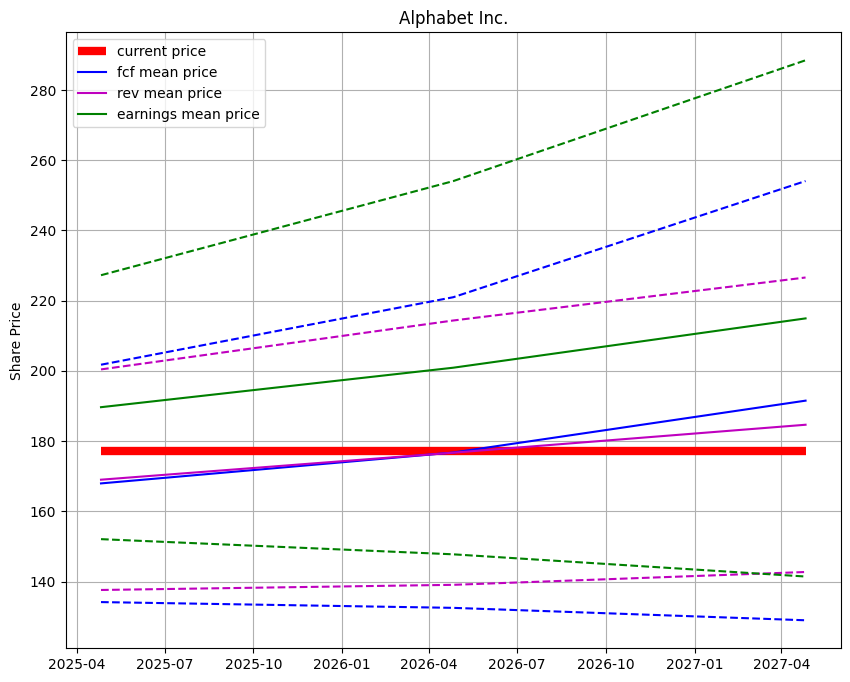

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.ylabel("Share Price")
ax.hlines(company.price_history.close[-1], year[0], year[-1], label="current price", color = "red", lw=6)
ax.plot(year, fcf_mean_price, label="fcf mean price", color="blue")
ax.plot(year, np.array(fcf_mean_price) + np.array(fcf_std_price), "--", color = "blue")
ax.plot(year, np.array(fcf_mean_price) - np.array(fcf_std_price), "--", color = "blue")
ax.plot(year, rev_mean_price, label="rev mean price", color="m")
ax.plot(year, np.array(rev_mean_price) + np.array(rev_std_price), "--", color = "m")
ax.plot(year, np.array(rev_mean_price) - np.array(rev_std_price), "--", color = "m")
ax.plot(year, earnings_mean_price, label="earnings mean price", color="green")
ax.plot(year, np.array(earnings_mean_price) + np.array(earnings_std_price), "--", color = "green")
ax.plot(year, np.array(earnings_mean_price) - np.array(earnings_std_price), "--", color = "green")
plt.title(company.profile.name)
plt.grid()
plt.legend()

## Sector Comparison

In [56]:
i = 0
sector_performance = fmpsdk.sectors_performance(apikey=api_key)
while sector_performance[i]['sector'] != company.profile.sector:
    i += 1
print(company.profile.sector)
print(fmpsdk.sectors_performance(apikey=api_key))
sector_performance = float(fmpsdk.sectors_performance(api_key)[i]['changesPercentage'][:-1]) * 10
print(sector_performance)

Communication Services
[{'sector': 'Basic Materials', 'changesPercentage': '0.44244%'}, {'sector': 'Communication Services', 'changesPercentage': '0.65959%'}, {'sector': 'Consumer Cyclical', 'changesPercentage': '-0.01937%'}, {'sector': 'Consumer Defensive', 'changesPercentage': '0.14808%'}, {'sector': 'Energy', 'changesPercentage': '0.70202%'}, {'sector': 'Financial Services', 'changesPercentage': '-0.36458%'}, {'sector': 'Healthcare', 'changesPercentage': '0.29899%'}, {'sector': 'Industrials', 'changesPercentage': '0.04722%'}, {'sector': 'Real Estate', 'changesPercentage': '-0.20866%'}, {'sector': 'Technology', 'changesPercentage': '-1.04119%'}, {'sector': 'Utilities', 'changesPercentage': '-0.82151%'}]
0.65959


In [11]:
from interface.data_sources.api_key import gemini_api_key
import google.generativeai as genai
import pathlib
import textwrap


genai.configure(api_key=gemini_api_key)
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content(ax)
print(response)


TypeError: Could not create `Blob`, expected `Blob`, `dict` or an `Image` type(`PIL.Image.Image` or `IPython.display.Image`).
Got a: <class 'matplotlib.axes._subplots.AxesSubplot'>
Value: AxesSubplot(0.125,0.11;0.775x0.77)